### Workbook to compute cross correlation data on the extracted time-series

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg' 
plb.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [2]:
import group_data as gd
import flylib
import pylab as plb

In [3]:
import os
swarm_data = dict()
for key in gd.swarms.keys():
    paths = dict()
    for fly in gd.swarms[key].flies:
        if not(os.path.exists(fly.fly_path + 'nnls_fits_no_bk_dF_F_corr_data.cpkl')):
            paths[fly.fly_num] =  {'fly_path':fly.fly_path,'fly_num':fly.fly_num}
    swarm_data[key] = paths

In [4]:
def get_signal_dict(fly_path):
    """extract a dictionary of signals for a given fly
    probably want to atach to the fly class"""
    import h5py
    import cPickle
    import numpy as np
    muscle_data_file = fly_path+'nnls_fits_no_bk_dF_F.cpkl'
    fly_record_file = fly_path+'fly_record.hdf5'
    signal_dict = dict()
    fi = open(muscle_data_file,'rb')
    muscle_data = cPickle.load(fi)
    fi.close()
    for mu,sig in zip(muscle_data['muscles'],muscle_data['fits']):
        signal_dict[mu] = sig
    hf = h5py.File(fly_record_file,'r')
    exp_record = hf['experiments'].values()[0]
    for key in exp_record['tiff_data']['axon_framebase'].keys():
        signal_dict[key] = np.array(exp_record['tiff_data']['axon_framebase'][key])
    hf.close()
    return signal_dict

In [5]:
#trim the swarm dict to remove any flies with problems
for swarm in swarm_data.values():
    for flykey in swarm.keys():
        fly = swarm[flykey]
        try:
            print fly['fly_num']
            fly['sigs'] = get_signal_dict(fly['fly_path'])
        except IOError as er:
            print flykey
            swarm.pop(flykey)
            print er

466
467
468
469
470
488
489
490
491
492
493
494
495
496
497
498
480
481
483
484
485
486
471
472
473
474
475
476
477
478
479


In [14]:
def get_line_database(line_name):
    """pull out the saved database of muscle expression proflies"""
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    """function to get list of muscles for a given line 
    should make this general and move to src/ """
    line_database = get_line_database(line_name)
    ln = line_name.split('_GFP')[0].split('GMR')[1]
    muscle_names = list()
    for key in line_database[ln].keys():
        if line_database[ln][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

def map_cross_cors(fly_num,sigs,muscle_list):
    """parallel function to calculate cross correlations""" 
    def calc_cross_cors(sigs,muscle_list):
        import flylib
        import numpy as np
        #reload(flylib)
        amp_corr_dict = dict()
        freq_corr_dict = dict()
        auto_corr_dict = dict()
        import flylib
        rwing = flylib.butter_bandpass_filter(sigs['Ph1'],0.02,20.0,0.022,order = 1)
        #rwing = np.array(sigs['Ph1'])
        wbf = sigs['wb_frequency']
        #wbf_filt = flylib.butter_bandpass_filter(wbf,0.02,20.0,0.022,order = 1)
        StimCond = sigs['StimCond']
        imlen = np.shape(sigs[muscle_list[0]])[0]
        mask = ((StimCond<0) & (wbf >150))[:imlen]
        times = sigs['times']
        dt = (times[1]-times[0])
        xcor_times = np.arange(0,np.sum(mask))*dt - dt*np.sum(mask)/2
        from scipy import signal
        for mname in muscle_list:
            if not('ps' in mname):
                msig = flylib.butter_bandpass_filter(sigs[mname],0.02,20.0,0.022,order = 1)
                amp_corr_dict[mname] = signal.correlate(msig[mask],rwing[mask],mode = 'same')
                freq_corr_dict[mname] = signal.correlate(msig[mask],wbf_filt[mask],mode = 'same')
                auto_corr_dict[mname] = signal.correlate(msig[mask],msig[mask],mode = 'same')
        return {'amp':amp_corr_dict,'freq':freq_corr_dict,'auto':auto_corr_dict,'times':xcor_times}
    return {fly_num:calc_cross_cors(sigs,muscle_list)}

In [11]:
#create a tuple of arguments to pass to the map function
map_data = dict()
for swarmkey in swarm_data.keys():
    if not(swarmkey in ['GMR22H05_prc','GMR22H05_pr']):
        muscle_list = get_muscle_list(swarmkey)
        map_data[swarmkey] = ([key for key in swarm_data[swarmkey].keys()],
                           [swarm_data[swarmkey][key]['sigs'] for key in swarm_data[swarmkey].keys()],
                           [muscle_list for key in swarm_data[swarmkey].keys()])

In [12]:
#get the ipython clients
from IPython.parallel import Client
clients = Client() 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


(14,)


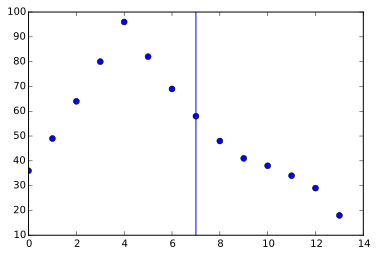

In [33]:
a = [1,1,1,1,2,3,4,5,6,1,1,1,1,1]
b = [1,2,3,4,5,6,1,1,1,1,1,1,1,1]
from scipy.signal import correlate
plot(correlate(b,a,mode = 'same'),'o')
print shape(a)
axvline(7)

(26,)


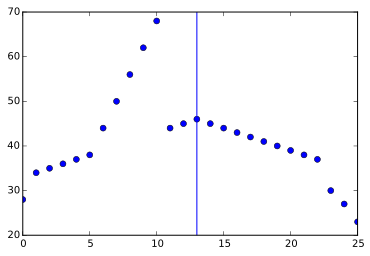

In [42]:
a = [1,1,1,1,1,1,1,1,1,1,1,1,6,5,4,3,2,1,1,1,1,1,1,1,1,1]
b = [1,1,1,1,1,1,1,1,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
from scipy.signal import correlate
plot(correlate(b,a,mode = 'same'),'o')
print shape(a)
axvline(shape(a)[0]/2)

In [13]:
#map in chunks by swarm
output_dict = dict()
for swarmkey in swarm_data.keys():
    if not(swarmkey in ['GMR22H05_prc','GMR22H05_pr']):
        print swarmkey
        output_dict[swarmkey] = v.map(map_cross_cors,*map_data[swarmkey])

GMR22H05_GFP
GMR31E10
GMR75B06_GFP
GMR22H05
GMR29E05_GFP
GMR39E01
GMR22H05_prc


KeyError: 'GMR22H05_prc'

In [43]:
#load the computed data back into the swarm_data dictionary
for swarmkey in swarm_data.keys():
    for i,fnum in enumerate([x.keys()[0] for x in output_dict[swarmkey]]):
        swarm_data[swarmkey][fnum]['corr_data'] =  output_dict[swarmkey][i].values()[0]

In [44]:
#save the dictionary as a pickle (need to write that dict to hdf5 wrapper)
import cPickle
f = open('extracted_sigs.cpkl','wb')
for swarmkey in swarm_data.keys():
    for fly in swarm_data[swarmkey].values():
        print fly['fly_path']
        print fly.keys()
        data_path =  fly['fly_path'] + 'nnls_fits_no_bk_dF_F_corr_data.cpkl'
        f = open(data_path,'wb')
        cPickle.dump(fly['corr_data'],f)
        f.close()

/media/FlyDataC/FlyDB/Fly0458/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0459/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0460/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0438/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0439/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0440/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0441/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0444/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0445/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0446/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0447/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0453/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDataC/FlyDB/Fly0455/
['corr_data', 'fly_num', 'sigs', 'fly_path']
/media/FlyDa

In [ ]:
#notify me that the batch is done
import smtplib
server = smtplib.SMTP( "smtp.gmail.com", 587 )
server.starttls()
server.login( 'thlindsay1@gmail.com', 'cyp4501a1' )
server.sendmail( 'test', '5412229957@txt.att.net', 'batch processing done' )

In [1]:
#ls -al /media/FlyDataC/FlyDB/Fly*/nnls_fits_no_bk_dF_F_corr_data.cpkl

In [45]:
#### construct an interpolated matrix of cross correlation data
xcor = list()
flynums = list()
sig_types = list()
muscle_names = list()
swarm_names = list()

for swarm_name,swarm in gd.swarms.items():
    for fly in swarm.flies:
        try:
            pkldata = fly.get_pkl_data('nnls_fits_no_bk_dF_F_corr_data.cpkl')
            x = pkldata['times']
            for sig_type_key in ['amp', 'freq', 'auto']:
                for mkey in pkldata[sig_type_key].keys():
                    y = pkldata[sig_type_key][mkey]
                    from scipy import interpolate
                    tck = interpolate.splrep(x, y, s=0)
                    xnew = np.arange(-100,100,0.01)
                    ynew = interpolate.splev(xnew, tck, der=0)
                    xcor.append(ynew)
                    muscle_names.append(mkey)
                    sig_types.append(sig_type_key)
                    swarm_names.append(swarm_name)
                    flynums.append(fly.fly_num)
        except IOError:
            print 'no input file'

xcor = np.array(xcor)
flynums = np.array(flynums)
sig_types = np.array(sig_types)
muscle_names = np.array(muscle_names)
swarm_names = np.array(swarm_names)

no input file


In [46]:
import os
os.remove('extracted_signal_correlations.hdf5')
import h5py
sig_cor = h5py.File('extracted_signal_correlations.hdf5')
sig_cor['xcor'] = xcor
sig_cor['fly_nums'] = flynums
sig_cor['sig_types'] = sig_types
sig_cor['muscle_names'] = muscle_names
sig_cor['swarm_names'] = swarm_names
sig_cor.flush()
sig_cor.close()